In [134]:
import pandas as pd

In [135]:
df=pd.read_csv('/content/DATA2025.csv',parse_dates=["Arrival_Date"], dayfirst=True)

In [136]:
df.duplicated().sum()

np.int64(0)

In [137]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4409 entries, 0 to 4408
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   State           4409 non-null   object        
 1   District        4409 non-null   object        
 2   Market          4409 non-null   object        
 3   Commodity       4409 non-null   object        
 4   Variety         4409 non-null   object        
 5   Grade           4409 non-null   object        
 6   Arrival_Date    4409 non-null   datetime64[ns]
 7   Min_Price       4409 non-null   float64       
 8   Max_Price       4409 non-null   int64         
 9   Modal_Price     4409 non-null   float64       
 10  Commodity_Code  4409 non-null   int64         
dtypes: datetime64[ns](1), float64(2), int64(2), object(6)
memory usage: 379.0+ KB


In [138]:
df.sort_values("Arrival_Date").tail()

,State,District,Market,Commodity,Variety,Grade,Arrival_Date,Min_Price,Max_Price,Modal_Price,Commodity_Code
4404,Maharashtra,Nashik,Lasalgaon,Onion,Red,Local,2025-11-20,451.0,1802,1301.0,23
4405,Maharashtra,Nashik,Lasalgaon,Onion,Red,Local,2025-11-21,300.0,2100,1351.0,23
4406,Maharashtra,Nashik,Lasalgaon,Onion,Other,Local,2025-11-21,400.0,1601,1151.0,23
4407,Maharashtra,Nashik,Lasalgaon,Onion,Other,Local,2025-11-22,400.0,1602,1175.0,23
4408,Maharashtra,Nashik,Lasalgaon,Onion,Red,Local,2025-11-22,400.0,1852,1100.0,23


In [139]:
df['Market'].value_counts()

,count
Market,
Manmad,448
Pimpalgaon Baswant(Saykheda),359
Pimpalgaon,302
Lasalgaon,285
Lasalgaon(Vinchur),268
Lasalgaon(Niphad),266
Chandvad,241
Yeola,231
Nasik,229


In [140]:
df["Grade"].value_counts()

,count
Grade,
Local,3930
FAQ,479


In [141]:
df_lasalgaon=df[df["Market"]=="Lasalgaon"].copy()

In [142]:
mean_table=df_lasalgaon.groupby(['Grade','Variety'],as_index=False)["Modal_Price"].mean()

In [143]:
mean_table

,Grade,Variety,Modal_Price
0,FAQ,Red,2267.190476
1,Local,Other,1447.514563
2,Local,Red,1900.017241


In [144]:
df_lasalgaon["Grade"].value_counts()

,count
Grade,
Local,264
FAQ,21


In [145]:
df_lasalgaon["Grade"].value_counts()

,count
Grade,
Local,264
FAQ,21


In [146]:
df['Variety'].value_counts()

,count
Variety,
Other,3252
Red,961
Pole,155
White,41


In [147]:
df_lasalgaon["Arrival_Date"].value_counts().sort_values(ascending=False)

,count
Arrival_Date,
2025-02-20,2
2025-02-19,2
2025-02-18,2
2025-02-17,2
2025-02-14,2
...,...
2025-11-07,1
2025-11-17,1
2025-11-15,1


In [148]:
df2025_daily=df_lasalgaon.groupby("Arrival_Date")["Modal_Price"].median()

In [149]:
df2025_daily=df2025_daily.reset_index()

In [150]:
df2025_daily.tail(10)

,Arrival_Date,Modal_Price
226,2025-11-10,1650.0
227,2025-11-12,1500.0
228,2025-11-13,1525.0
229,2025-11-14,1500.0
230,2025-11-15,1500.0
231,2025-11-17,1425.0
232,2025-11-19,1450.5
233,2025-11-20,1350.5
234,2025-11-21,1251.0
235,2025-11-22,1137.5


In [151]:
import pickle
from datetime import timedelta
from copy import deepcopy
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import classification_report, accuracy_score
import joblib
import xgboost as xgb
import shap

In [152]:
RAINFALL_CSV = "RainfallData2025.csv"
FESTIVAL_CSV = "festival_dates_lasalgaon_onion_prices.csv"
GOVT_CSV = "onion_government_interventions_lasalgaon_2013_2025.csv"
MODEL_PATH = "xgb_final_all_data.model"
OUT_FEATURES = "2025_features.csv"
OUT_PRED = "2025_predictions.csv"

In [153]:
FEATURES = [
 'log_ret',
 'log_return_lag1',
 'vol_7',
 'vol_7_lag1',
 'vol_30',
 'vol_30_lag1',
 'rainfall_7d',
 'rainfall_7d_lag1',
 'festival_window',
 'days_since_last_arrival',
 'is_price_jump',
 'price_momentum_7',
 'price_momentum_3',
 'month_sin',
 'month_cos',
 'dow_sin',
 'dow_cos',
 'govt_window',
 'govt_none',
 'govt_buffer_operations',
 'govt_export_restriction',
 'govt_farmer_actions',
 'govt_import_support',
 'govt_market_intervention',
 'govt_procurement_support',
 'govt_stock_limit_actions'
]

In [154]:
def build_calendar(df_daily, start_date, end_date):
    cal = pd.DataFrame({"Arrival_Date": pd.date_range(start_date, end_date, freq="D")})
    cal = cal.merge(df_daily, on="Arrival_Date", how="left")
    return cal

In [155]:
def safe_impute_prices(calendar, max_gap=3):
    cal = calendar.copy()
    cal["Modal_Price_ffill"] = cal["Modal_Price"].ffill()
    cnt = 0; days=[]
    for _, r in cal.iterrows():
        if not pd.isna(r["Modal_Price"]):
            cnt = 0; days.append(0)
        else:
            cnt += 1; days.append(cnt)
    cal["days_from_last_obs"] = days
    cal["Modal_Price_imp"] = cal["Modal_Price_ffill"].where(cal["days_from_last_obs"] <= max_gap, np.nan)
    cal["Modal_Price"] = cal["Modal_Price"].combine_first(cal["Modal_Price_imp"])
    return cal

In [156]:
def compute_returns_vols(cal):
    cal = cal.copy()
    cal["log_ret"] = np.log(cal["Modal_Price"] / cal["Modal_Price"].shift(1)).fillna(0.0)
    cal["log_return_lag1"] = cal["log_ret"].shift(1).fillna(0.0)
    cal["vol_7"] = cal["log_ret"].rolling(window=7, min_periods=3).std().fillna(0.0)
    cal["vol_30"] = cal["log_ret"].rolling(window=30, min_periods=7).std().fillna(0.0)
    cal["vol_7_lag1"] = cal["vol_7"].shift(1).fillna(0.0)
    cal["vol_30_lag1"] = cal["vol_30"].shift(1).fillna(0.0)
    return cal

In [157]:
def compute_rainfall(cal, rainfall_df):
    rf = rainfall_df.copy()
    val_col = "precipitation_sum (mm)"

    rf["Date"]=pd.to_datetime(rf["Date"], dayfirst=True).dt.normalize()
    rain_map = rf.set_index("Date")[val_col].to_dict()
    cal["rain_mm"] = cal["Arrival_Date"].map(rain_map).fillna(0.0)
    cal["rainfall_7d"] = cal["rain_mm"].rolling(window=7, min_periods=1).sum().fillna(0.0)
    cal["rainfall_7d_lag1"] = cal["rainfall_7d"].shift(1).fillna(0.0)
    return cal

In [158]:
def add_calendar_features(cal):
    cal["month"] = cal["Arrival_Date"].dt.month
    cal["dow"] = cal["Arrival_Date"].dt.dayofweek
    # cyclic encodings
    cal["month_sin"] = np.sin(2*np.pi*(cal["month"]-1)/12)
    cal["month_cos"] = np.cos(2*np.pi*(cal["month"]-1)/12)
    cal["dow_sin"] = np.sin(2*np.pi*cal["dow"]/7)
    cal["dow_cos"] = np.cos(2*np.pi*cal["dow"]/7)
    return cal

In [159]:
def add_festival_window(cal, festival_df, window=2):
    fest = festival_df.copy()
    fest['festival_dates']=pd.to_datetime(fest['festival_dates'],dayfirst=True).dt.normalize()
    date_col = fest.columns[0]
    fest_set = set(fest[date_col])
    fest_days = set()
    for d in fest_set:
        for w in range(-window,window+1):
            fest_days.add((pd.Timestamp(d) + pd.Timedelta(days=w)).normalize())
    cal["festival_window"] = cal["Arrival_Date"].isin(fest_days).astype(int)
    return cal

In [160]:
def compute_days_since_last_arrival(cal):
    days = []
    last = None
    for _, r in cal.iterrows():
        if r["Modal_Price"]>0:
            last = r["Arrival_Date"]
            days.append(0)
        else:
            if last is None:
                days.append(1)
            else:
                days.append((r["Arrival_Date"] - last).days)
    cal["days_since_last_arrival"] = days
    cal["days_since_last_arrival"] = cal["days_since_last_arrival"].clip(0,10)
    return cal

In [161]:
def compute_price_jump_and_momentum(cal):
    cal["is_price_jump"] = (cal['log_ret'].abs()>2*cal['vol_30']).astype(int)
    # momentum: sum of log returns over window (or mean) — use rolling sum of log_ret
    cal["price_momentum_7"] = cal["log_ret"].rolling(window=7, min_periods=1).sum().fillna(0.0)
    cal["price_momentum_3"] = cal["log_ret"].rolling(window=3, min_periods=1).sum().fillna(0.0)
    return cal

In [162]:
GOVT_MAP = {
    "export restriction - mep": "govt_export_restriction",
    "export ban": "govt_export_restriction",
    "export policy": "govt_export_restriction",
    "buffer stock": "govt_buffer_operations",
    "buffer stock release": "govt_buffer_operations",
    "stock limit": "govt_stock_limit_actions",
    "stock limit revision": "govt_stock_limit_actions",
    "import facilitation": "govt_import_support",
    "import action": "govt_import_support",
    "market intervention": "govt_market_intervention",
    "market monitoring": "govt_market_intervention",
    "market relief": "govt_market_intervention",
    "market development": "govt_market_intervention",
    "retail sales intervention": "govt_market_intervention",
    "procurement request": "govt_procurement_support",
    "procurement support": "govt_procurement_support",
    "state relief": "govt_procurement_support",
    "policy liberalization": "govt_procurement_support",
    "farmer action": "govt_farmer_actions",
    "farmer protest": "govt_farmer_actions",
    "export duty": "govt_export_restriction",
    "export ban extension": "govt_export_restriction",
}

In [163]:
def process_govt_interventions(govt_df, window=3):
    g = govt_df.copy()
    g["Date"] = pd.to_datetime(g["Date"], dayfirst=True).dt.normalize()
    g["Category"] = g["Category"].astype(str).str.lower().str.strip()


    gov_map = {}
    for idx, row in g.iterrows():
        d = row["Date"]
        cat = row["Category"]
        mapped = None
        for key in GOVT_MAP:
            if key in cat:
                mapped = GOVT_MAP[key]
                break
        if mapped is None:
            continue
        for w in range(-window, window+1):
            dt = (d + pd.Timedelta(days=w)).normalize()
            if dt not in gov_map:
                gov_map[dt] = set()
            gov_map[dt].add(mapped)
    return gov_map

In [164]:
def add_govt_flags(cal, gov_map):
    cal = cal.copy()
    cal["Arrival_Date"] = pd.to_datetime(cal["Arrival_Date"]).dt.normalize()

    gov_cols = [c for c in FEATURES if c.startswith("govt_")]
    for c in gov_cols:
        if c not in cal.columns:
            cal[c] = 0

    for i, r in cal.iterrows():
        d = r["Arrival_Date"]
        if d in gov_map:
            flags = gov_map[d]
            cal.at[i, "govt_window"] = 1
            for f in flags:
                if f in cal.columns:
                    cal.at[i, f] = 1
    return cal

In [165]:
def cvi_score_from_proba(proba):
    p = np.array(proba)
    return float(p[1]*50 + p[2]*100)

def cvi_label_from_score(score):
    if score < 28.478758096694946:
      return "Low"
    elif score < 71.50789070129395:
      return "Medium"
    else:
      return "High"

In [166]:
def predict_proba(model, X):
    Xf = X.fillna(0.0)
    dmat = xgb.DMatrix(Xf.values, feature_names=Xf.columns.tolist())
    out=model.predict(dmat)
    return out

In [167]:
# Multi-step forecast (recursive) — uses last row to simulate next days
def make_feature_row(base_df, predict_date, rainfall_map, festival_set):
    last = base_df.iloc[-1]
    feat = {}

    feat["Modal_Price"] = last.get("Modal_Price", 0.0)
    feat["log_ret"] = last.get("log_ret", 0.0)
    feat["log_return_lag1"] = last.get("log_return_lag1", 0.0)
    feat["vol_7"] = last.get("vol_7", 0.0)
    feat["vol_7_lag1"] = last.get("vol_7_lag1", 0.0)
    feat["vol_30"] = last.get("vol_30", 0.0)
    feat["vol_30_lag1"] = last.get("vol_30_lag1", 0.0)
    feat["rainfall_7d"] = last.get("rainfall_7d", 0.0)
    feat["rainfall_7d_lag1"] = last.get("rainfall_7d_lag1", 0.0)
    feat["festival_window"] = 1 if predict_date in festival_set else 0
    feat["days_since_last_arrival"] = last.get("days_since_last_arrival", 0) + 1
    feat["is_price_jump"] = 0
    feat["price_momentum_7"] = last.get("price_momentum_7", 0.0)
    feat["price_momentum_3"] = last.get("price_momentum_3", 0.0)
    # cyclic features for date
    m = predict_date.month;
    dow = predict_date.dayofweek
    feat["month_sin"] = np.sin(2*np.pi*(m-1)/12)
    feat["month_cos"] = np.cos(2*np.pi*(m-1)/12)
    feat["dow_sin"] = np.sin(2*np.pi*dow/7)
    feat["dow_cos"] = np.cos(2*np.pi*dow/7)

    for c in FEATURES:
        if c.startswith("govt_"):
            feat[c] = 0

    row = pd.DataFrame([feat])[FEATURES].fillna(0.0)
    return row, feat

In [168]:
def multi_step_cvi(base_df, model, n_steps=[1,3,7], rainfall_map=None, festival_set=set()):
    base = deepcopy(base_df.sort_values("Arrival_Date").reset_index(drop=True))
    results = {}
    max_s = max(n_steps)
    for s in range(1, max_s+1):
        next_date = base["Arrival_Date"].max() + timedelta(days=1)
        Xrow, featdict = make_feature_row(base, next_date, rainfall_map, festival_set)
        proba = predict_proba(model, Xrow)[0].tolist()
        score = cvi_score_from_proba(proba)
        label = cvi_label_from_score(score)
        if s in n_steps:
            results[next_date.strftime("%Y-%m-%d")] = {"proba": proba, "score": score, "label": label}
        # append pseudo-row to base
        pseudo = {"Arrival_Date": next_date}
        for k,v in featdict.items():
          pseudo[k] = v
        base = pd.concat([base, pd.DataFrame([pseudo])], ignore_index=True)
    return results

In [169]:
def price_direction(m7,m3):
  if (m7>0.03) and (m3>0.02):#used suitable values after referring preds_df percentiles for price momentums
    return "Up"
  elif (m7<-0.03) and (m3<-0.02):
    return "Down"
  else:
    return "Stable"

In [170]:
def run_pipeline():
    raw = df2025_daily
    raw["Arrival_Date"] = pd.to_datetime(raw["Arrival_Date"], dayfirst=True).dt.normalize()

    daily=raw.copy()

    #Build calendar for 2025 entire year (so UI can query any day in 2025)
    cal = build_calendar(daily, start_date=pd.Timestamp("2025-01-01"), end_date=pd.Timestamp("2025-12-31"))

    #Impute short gaps
    cal = safe_impute_prices(cal, max_gap=3)

    #returns & vols
    cal = compute_returns_vols(cal)

    #rainfall
    rf = pd.read_csv('/content/RainfallData2025.csv')
    rf["Date"] = pd.to_datetime(rf["Date"], dayfirst=True).dt.normalize()
    cal = compute_rainfall(cal, rf)

    #calendar cyclic
    cal = add_calendar_features(cal)

    #festivals
    fest = pd.read_csv('/content/festival_dates_lasalgaon_onion_prices.csv')
    fest["festival_dates"] = pd.to_datetime(fest["festival_dates"], dayfirst=True).dt.normalize()
    cal = add_festival_window(cal, fest)

    #days since last arrival
    cal = compute_days_since_last_arrival(cal)

    #jumps and momenta
    cal = compute_price_jump_and_momentum(cal)

    #government interventions
    gov = pd.read_csv('/content/onion_government_interventions_lasalgaon_2013_2025.csv')
    gov["Date"]=pd.to_datetime(gov["Date"], dayfirst=True).dt.normalize()
    gov_map = process_govt_interventions(gov)
    cal = add_govt_flags(cal, gov_map)

    for f in FEATURES:
        if f not in cal.columns:
            cal[f] = 0.0

    #reorder to have Arrival_Date then features
    features_df = cal[["Arrival_Date"] + FEATURES].copy()
    features_df = features_df.fillna(0.0)

    #Save features
    features_df.to_csv(OUT_FEATURES, index=False)
    print("Saved features ->", OUT_FEATURES)

    #Load model and predict
    bst=xgb.Booster()
    bst.load_model(MODEL_PATH)
    model = bst

    X = features_df[FEATURES]
    proba = predict_proba(model, X)
    proba = np.array(proba)
    scores = [cvi_score_from_proba(p) for p in proba]
    labels = [cvi_label_from_score(s) for s in scores]
    preds_df = pd.DataFrame({
        "date": features_df["Arrival_Date"].dt.strftime("%Y-%m-%d"),
        "cvi_score": np.round(scores,3),
        "cvi_label": labels,
        "prob_low": np.round(proba[:,0],4),
        "prob_med": np.round(proba[:,1],4),
        "prob_high": np.round(proba[:,2],4)
    })


    cal['date_str']=cal['Arrival_Date'].dt.strftime("%Y-%m-%d")

    preds_df = preds_df.merge(cal[["Arrival_Date","price_momentum_7","price_momentum_3","vol_7","vol_30"]],
                              left_on="date", right_on=cal["date_str"], how="left")
    preds_df = preds_df.drop(columns=[cal["Arrival_Date"].name])

    #adding price_movement
    preds_df['price_movement'] = preds_df.apply(lambda row: price_direction(row['price_momentum_7'], row['price_momentum_3']), axis=1)

    #multi-step forecast (1/3/7)
    festival_set = set(fest["festival_dates"])
    rainfall_map = rf.set_index("Date")["precipitation_sum (mm)"].to_dict()
    multi = multi_step_cvi(cal, model, n_steps=[1,3,7], rainfall_map=rainfall_map, festival_set=festival_set)

    # add multi-step results as separate JSON-like column
    preds_df["multi_next"] = str(multi)

    #Save predictions
    preds_df.to_csv(OUT_PRED, index=False)
    print("Saved predictions ->", OUT_PRED)

    try:
        print("Computing SHAP values (may take a moment)...")
        explainer = shap.TreeExplainer(model)
        shap_vals = explainer.shap_values(X)
        with open("shap_values_2025.pkl", "wb") as f:
            pickle.dump(shap_vals, f)
        print("Saved SHAP -> shap_values_2025.pkl")
    except Exception as e:
        print("SHAP step failed:", e)
    print("Pipeline done. Files:", OUT_FEATURES, OUT_PRED)

In [171]:
run_pipeline()

Saved features -> 2025_features.csv
Saved predictions -> 2025_predictions.csv
Computing SHAP values (may take a moment)...


/tmp/ipython-input-1117911144.py:55: UserWarning: [14:49:21] WARNING: /workspace/src/c_api/c_api.cc:1511: Unknown file format: `model`. Using UBJSON (`ubj`) as a guess.
  bst.load_model(MODEL_PATH)


Saved SHAP -> shap_values_2025.pkl
Pipeline done. Files: 2025_features.csv 2025_predictions.csv


In [172]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [173]:
# Load features and predictions
features_df = pd.read_csv("2025_features.csv", parse_dates=["Arrival_Date"])
preds_df = pd.read_csv("2025_predictions.csv", parse_dates=["date"])

In [174]:
# ensure date columns are datetime
features_df['Arrival_Date'] = pd.to_datetime(features_df['Arrival_Date']).dt.normalize()
preds_df['date'] = pd.to_datetime(preds_df['date']).dt.normalize()

In [175]:
features_df = features_df.sort_values('Arrival_Date').reset_index(drop=True)
features_df['vol_7_next'] = features_df['vol_7'].shift(-1)
features_df['year'] = features_df['Arrival_Date'].dt.year

In [176]:
def classify_2025(v):
    if v < 0.05316398313903646:
        return "Low"
    elif v < 0.08882703501291653:
        return "Medium"
    else:
        return "High"

features_df['vol_class_global'] = features_df['vol_7_next'].apply(classify_2025)


In [177]:
features_df.head()

,Arrival_Date,log_ret,log_return_lag1,vol_7,vol_7_lag1,vol_30,vol_30_lag1,rainfall_7d,rainfall_7d_lag1,festival_window,...,govt_buffer_operations,govt_export_restriction,govt_farmer_actions,govt_import_support,govt_market_intervention,govt_procurement_support,govt_stock_limit_actions,vol_7_next,year,vol_class_global
0,2025-01-01,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0,...,0,0,1,0,0,0,0,0.000000,2025,Low
1,2025-01-02,-0.020611,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0,...,0,0,1,0,0,0,0,0.011781,2025,Low
2,2025-01-03,-0.000417,-0.020611,0.011781,0.000000,0.0,0.0,0.0,0.0,0,...,0,0,0,0,0,0,0,0.025778,2025,Low
3,2025-01-04,0.040822,-0.000417,0.025778,0.011781,0.0,0.0,0.0,0.0,0,...,0,0,0,0,0,0,0,0.022434,2025,Low
4,2025-01-05,0.000000,0.040822,0.022434,0.025778,0.0,0.0,0.0,0.0,0,...,0,0,0,0,0,0,0,0.020130,2025,Low


In [178]:
features_df['Arrival_Date'] = pd.to_datetime(features_df['Arrival_Date'])
preds_df['date'] = pd.to_datetime(preds_df['date'])

eval_df = features_df.merge(preds_df[['date','cvi_label','price_movement']],
    left_on='Arrival_Date',right_on='date',
    how='inner')

In [179]:
preds_df['price_momentum_3'].describe(percentiles=[0.05,0.25,0.5,0.75,0.95])

,price_momentum_3
count,365.000000
mean,-0.004099
std,0.082111
min,-0.278227
5%,-0.157062
25%,-0.036368
50%,0.000000
75%,0.030991
95%,0.120467
max,0.314711


In [180]:
preds_df['price_momentum_7'].describe(percentiles=[0.05,0.25,0.5,0.75,0.95])

,price_momentum_7
count,365.000000
mean,-0.009565
std,0.122959
min,-0.459028
5%,-0.252614
25%,-0.057862
50%,0.000000
75%,0.042560
95%,0.199286
max,0.441183


In [181]:
last_true_date= df2025_daily[df2025_daily['Modal_Price']!=0]['Arrival_Date'].max()

In [182]:
preds_df.head()

,date,cvi_score,cvi_label,prob_low,prob_med,prob_high,price_momentum_7,price_momentum_3,vol_7,vol_30,price_movement,multi_next
0,2025-01-01,2.231,Low,0.9621,0.0311,0.0068,0.000000,0.000000,0.000000,0.0,Stable,"{'2026-01-01': {'proba': [0.9489948749542236, ..."
1,2025-01-02,4.507,Low,0.9247,0.0604,0.0149,-0.020611,-0.020611,0.000000,0.0,Stable,"{'2026-01-01': {'proba': [0.9489948749542236, ..."
2,2025-01-03,5.227,Low,0.9144,0.0667,0.0189,-0.021027,-0.021027,0.011781,0.0,Stable,"{'2026-01-01': {'proba': [0.9489948749542236, ..."
3,2025-01-04,14.604,Low,0.7646,0.1787,0.0567,0.019795,0.019795,0.025778,0.0,Stable,"{'2026-01-01': {'proba': [0.9489948749542236, ..."
4,2025-01-05,4.677,Low,0.9198,0.0668,0.0134,0.019795,0.040405,0.022434,0.0,Stable,"{'2026-01-01': {'proba': [0.9489948749542236, ..."


In [183]:

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
eval_df = eval_df[eval_df['Arrival_Date'] <= last_true_date]
ytrue = eval_df['vol_class_global']
ypred = eval_df['cvi_label']

target_names=["Low","Medium","High"]
labels_order=["Low","Medium","High"]
print("Accuracy:", accuracy_score(ytrue, ypred))
print("\nClassification Report:\n", classification_report(ytrue, ypred,labels=labels_order,target_names=target_names))
cm=confusion_matrix(ytrue, ypred, labels=labels_order)
print("\nConfusion Matrix:\n", cm)


Accuracy: 0.8957055214723927

Classification Report:
               precision    recall  f1-score   support

         Low       0.96      0.92      0.94       259
      Medium       0.67      0.79      0.72        53
        High       0.86      0.86      0.86        14

    accuracy                           0.90       326
   macro avg       0.83      0.86      0.84       326
weighted avg       0.90      0.90      0.90       326


Confusion Matrix:
 [[238  19   2]
 [ 11  42   0]
 [  0   2  12]]


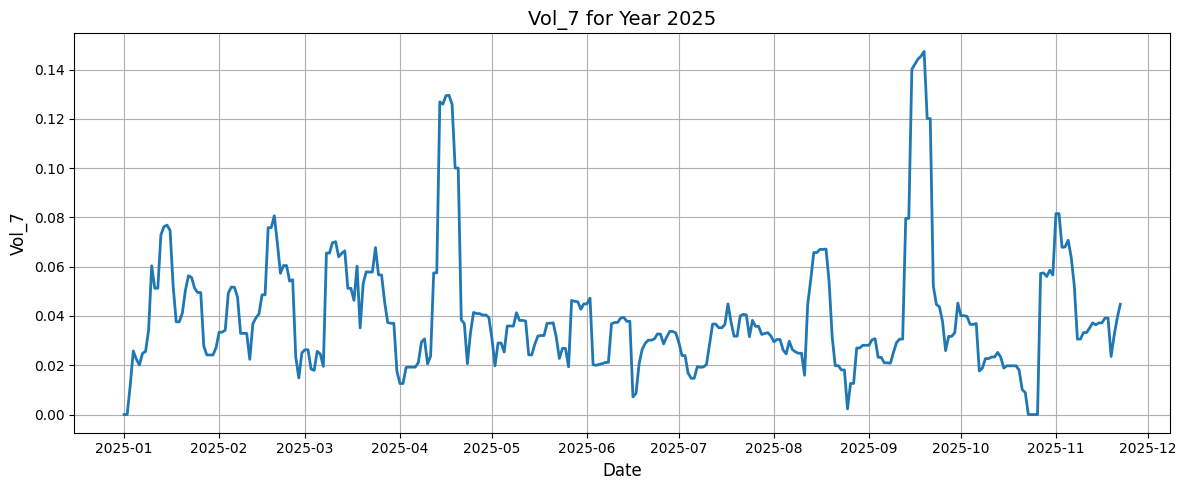

In [184]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(eval_df['Arrival_Date'], eval_df['vol_7'], linewidth=2)
plt.title("Vol_7 for Year 2025", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Vol_7", fontsize=12)

plt.grid(True)
plt.tight_layout()
plt.show()

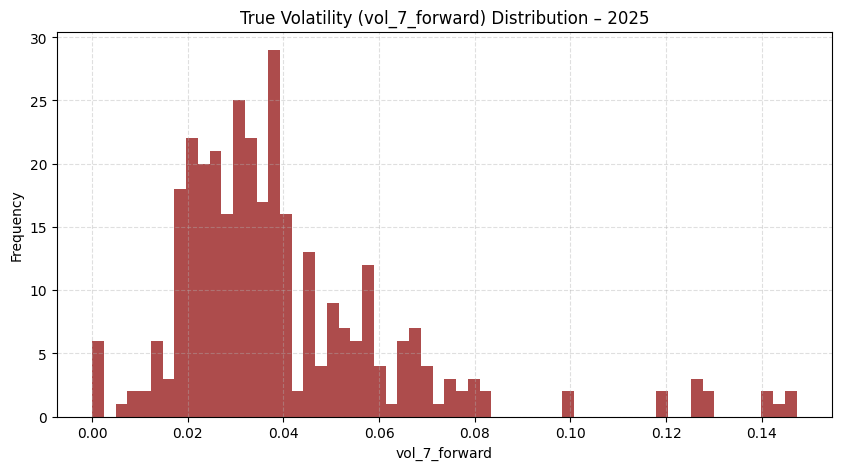

In [185]:


plt.figure(figsize=(10,5))
plt.hist(eval_df['vol_7_next'], bins=60, alpha=0.7, color='darkred')
plt.title("True Volatility (vol_7_forward) Distribution – 2025")
plt.xlabel("vol_7_forward")
plt.ylabel("Frequency")
plt.grid(True, linestyle='--', alpha=0.4)
plt.show()


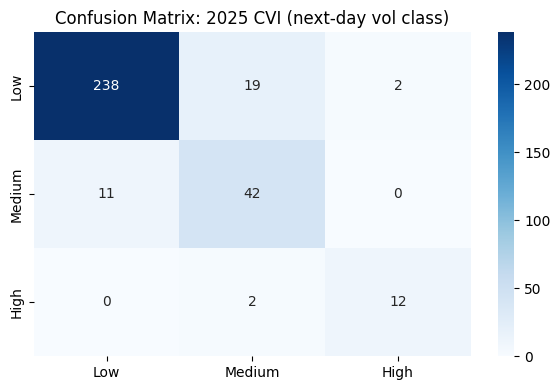

In [187]:
cm_df=pd.DataFrame(cm, index=['Low','Medium','High'], columns=['Low','Medium','High'])
plt.figure(figsize=(6,4))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix: 2025 CVI (next-day vol class)")
plt.tight_layout()
plt.show()

In [188]:
eval_df.to_csv("preds_2025_with_truth.csv",index=False)
print("Success")

Success
